In [ ]:
from google.colab import files
import zipfile
import os

# Upload ZIP file
uploaded = files.upload()

# Extract ZIP if uploaded
for fn in uploaded.keys():
    if fn.endswith(".zip"):
        print("Extracting:", fn)
        with zipfile.ZipFile(fn, 'r') as zip_ref:
            zip_ref.extractall("/content/SPE3_data")
        print("Extraction complete.")

# Show extracted files
os.listdir("/content/SPE3_data")


Saving spe3.zip to spe3.zip
Extracting: spe3.zip
Extraction complete.


['spe3']

In [ ]:
import os

root = "/content/SPE3_data"
for path, subdirs, files in os.walk(root):
    for file in files:
        print(os.path.join(path, file))


/content/SPE3_data/spe3/SPE3CASE1.DATA
/content/SPE3_data/spe3/SPE3CASE2.DATA


In [ ]:
import re

data_path = "/content/SPE3_data/spe3/SPE3CASE1.DATA"

# Read file
with open(data_path, 'r') as f:
    text = f.read().upper()   # uppercase so we can match keywords

# Function to extract tables between a keyword and terminating slash "/"
def extract_table(keyword, text):
    pattern = keyword + r"\s*(.*?)\s*/"
    match = re.search(pattern, text, re.S)
    if match:
        raw = match.group(1).strip()
        rows = []

        for line in raw.splitlines():
            parts = line.split()
            if len(parts) >= 2:
                rows.append(parts)
        return rows
    return None

# Extract oil–water
swof_raw = extract_table("SWOF", text)
# Extract gas–oil
sgof_raw = extract_table("SGOF", text)

print("SWOF found:", "Yes" if swof_raw else "No")
print("SGOF found:", "Yes" if sgof_raw else "No")


SWOF found: Yes
SGOF found: Yes


In [ ]:
import pandas as pd
import numpy as np

def parse_table(raw_rows):
    # Convert list of ['0.2','0.001','0.8','0'] → float table
    parsed = []
    for r in raw_rows:
        try:
            parsed.append([float(x) for x in r[:4]])  # Sw/Sg, krw/krg, kro/krog, pc
        except:
            pass
    return pd.DataFrame(parsed, columns=["Sat", "kr1", "kr2", "Pc"])

# Parse SWOF and SGOF into DataFrames
df_swof = parse_table(swof_raw)
df_sgof = parse_table(sgof_raw)

print("SWOF head:")
display(df_swof.head())

print("SGOF head:")
display(df_sgof.head())


SWOF head:


,Sat,kr1,kr2,Pc
0,0.16,0.000,0.800,50.0
1,0.20,0.002,0.650,32.0
2,0.24,0.010,0.513,21.0
3,0.28,0.020,0.400,15.5
4,0.32,0.033,0.315,12.0


SGOF head:


,Sat,kr1,kr2,Pc
0,0.00,0.000,0.800,0.0
1,0.04,0.005,0.650,0.0
2,0.08,0.013,0.513,0.0
3,0.12,0.026,0.400,0.0
4,0.16,0.040,0.315,0.0


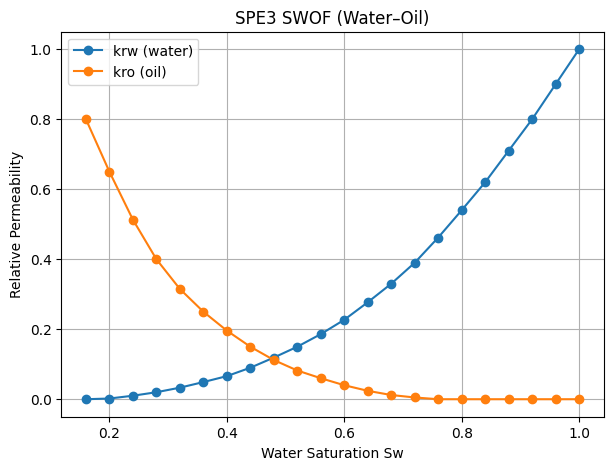

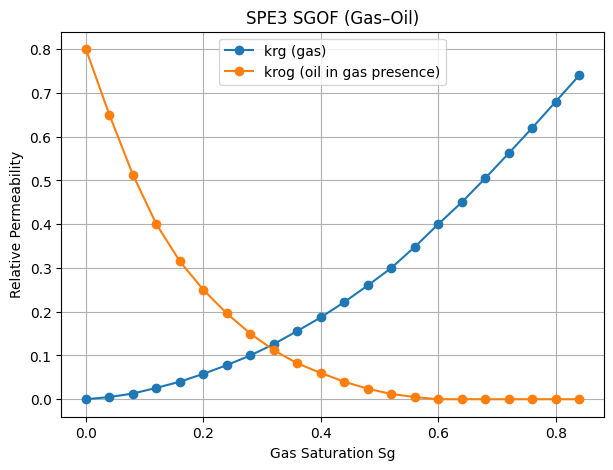

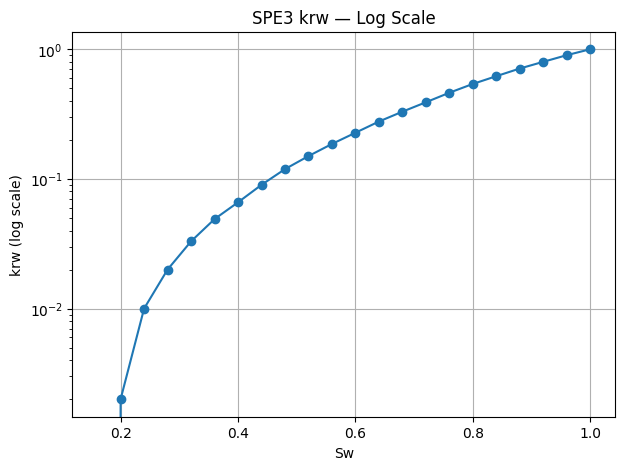

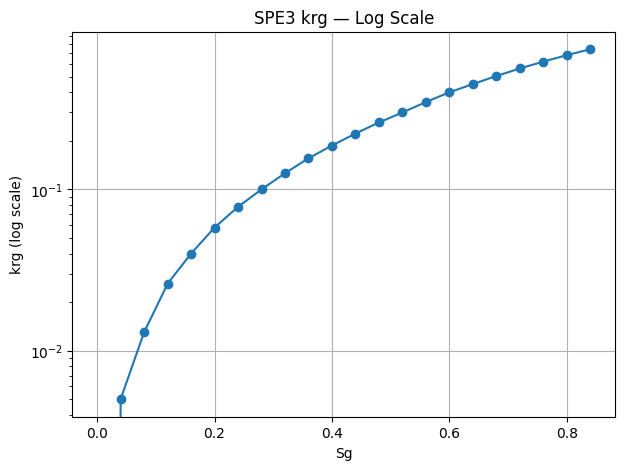

In [ ]:
import matplotlib.pyplot as plt

# Plot SWOF (oil–water)
plt.figure(figsize=(7,5))
plt.plot(df_swof["Sat"], df_swof["kr1"], 'o-', label='krw (water)')
plt.plot(df_swof["Sat"], df_swof["kr2"], 'o-', label='kro (oil)')
plt.xlabel("Water Saturation Sw")
plt.ylabel("Relative Permeability")
plt.title("SPE3 SWOF (Water–Oil)")
plt.grid(True)
plt.legend()
plt.show()

# Plot SGOF (gas–oil)
plt.figure(figsize=(7,5))
plt.plot(df_sgof["Sat"], df_sgof["kr1"], 'o-', label='krg (gas)')
plt.plot(df_sgof["Sat"], df_sgof["kr2"], 'o-', label='krog (oil in gas presence)')
plt.xlabel("Gas Saturation Sg")
plt.ylabel("Relative Permeability")
plt.title("SPE3 SGOF (Gas–Oil)")
plt.grid(True)
plt.legend()
plt.show()

# krw log scale
plt.figure(figsize=(7,5))
plt.semilogy(df_swof["Sat"], df_swof["kr1"], 'o-')
plt.xlabel("Sw")
plt.ylabel("krw (log scale)")
plt.title("SPE3 krw — Log Scale")
plt.grid(True)
plt.show()

# krg log scale
plt.figure(figsize=(7,5))
plt.semilogy(df_sgof["Sat"], df_sgof["kr1"], 'o-')
plt.xlabel("Sg")
plt.ylabel("krg (log scale)")
plt.title("SPE3 krg — Log Scale")
plt.grid(True)
plt.show()


SWOF endpoints estimate: Swi = 0.2  Sor = 0.28
SGOF endpoints estimate: Sgc = 0.04  Sorg = 0.43999999999999995

SWOF fit results:
Swi, Sor: 0.2 0.28
nw, no, krw0, kro0: 4.060350177076946 2.721602251043004 0.6636083738981771 0.6940984212757462
SWOF RMSE (combined): 0.09405296911791552

SGOF fit results:
Sgc, Sorg: 0.04 0.43999999999999995
ng, no(g), krg0, krog0: 2.884081457095105 2.721601201658348 0.5234506502287806 0.6940983583238454
SGOF RMSE (combined): 0.06457732504653747

Outputs saved to: /content/SPE3_SCAL_outputs
Files: [PosixPath('/content/SPE3_SCAL_outputs/SPE3_SWOF_original_parsed.csv'), PosixPath('/content/SPE3_SCAL_outputs/SPE3_SGOF_original_parsed.csv'), PosixPath('/content/SPE3_SCAL_outputs/SPE3_SGOF_corey_plot.png'), PosixPath('/content/SPE3_SCAL_outputs/SPE3_SGOF_corey_fit.csv'), PosixPath('/content/SPE3_SCAL_outputs/SPE3_SWOF_corey_plot.png'), PosixPath('/content/SPE3_SCAL_outputs/SPE3_SWOF_corey_fit.csv'), PosixPath('/content/SPE3_SCAL_outputs/SPE3_corey_fit_summary.c

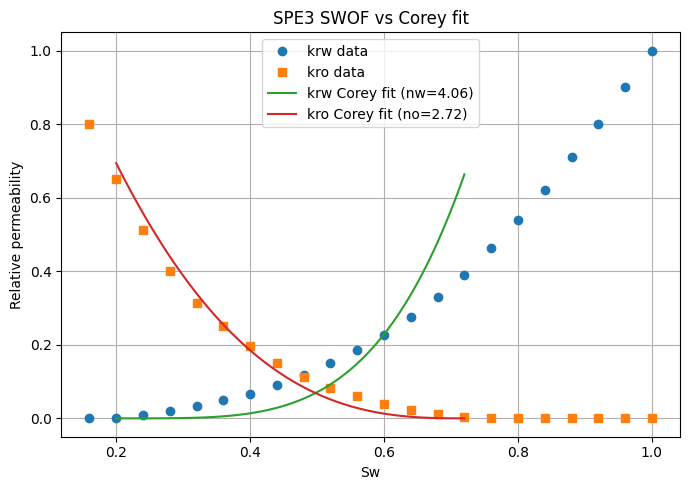

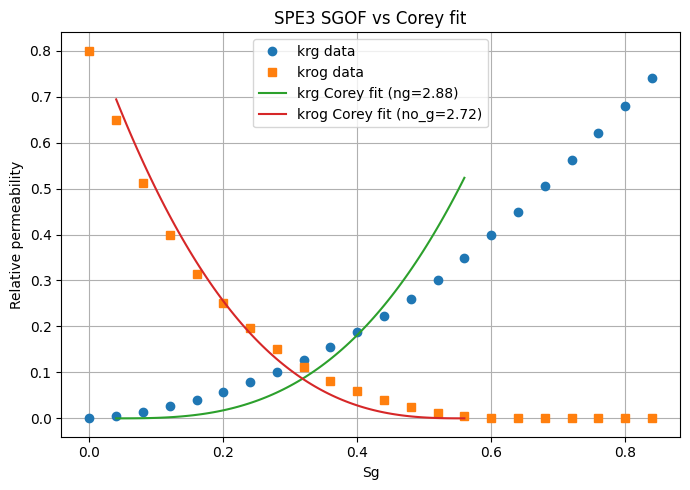

In [ ]:
# ----------------------------
# SPE3: Corey fit for SWOF & SGOF
# Paste into your SPE3 Colab notebook and run.
# Assumes df_swof and df_sgof are present (columns: Sat, kr1, kr2, Pc)
# ----------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from pathlib import Path
from math import sqrt
outdir = Path("/content/SPE3_SCAL_outputs")
outdir.mkdir(parents=True, exist_ok=True)

# Use local df_swof, df_sgof from your notebook
# If not defined, you can load from previous parsing results
# df_swof = pd.read_csv('/content/.../SPE3_SWOF_original_parsed.csv')   # example
# df_sgof = pd.read_csv('/content/.../SPE3_SGOF_original_parsed.csv')

# Rename columns for clarity
df_swof = df_swof.rename(columns={"Sat":"Sw","kr1":"krw","kr2":"kro","Pc":"pcow"})
df_sgof = df_sgof.rename(columns={"Sat":"Sg","kr1":"krg","kr2":"krog","Pc":"pcgo"})

# --- Helper: estimate endpoints ---
def estimate_endpoints_two_phase(S, k1, k2, small1=1e-9, small2=1e-6):
    # S: saturation array
    # find Swi as first S where k1 > small1
    try:
        Swi = float(S[k1 > small1].min())
    except:
        Swi = float(S.min())
    # find Sor = 1 - max S where k2 > small2
    try:
        S_k2_nonzero_max = float(S[k2 > small2].max())
        Sor = 1.0 - S_k2_nonzero_max
    except:
        Sor = 1.0 - float(S.max())
    return Swi, Sor

# estimate SWOF endpoints
Sw_arr = df_swof['Sw'].values
krw_arr = df_swof['krw'].values
kro_arr = df_swof['kro'].values

Swi_est, Sor_est = estimate_endpoints_two_phase(df_swof['Sw'], df_swof['krw'], df_swof['kro'])
print("SWOF endpoints estimate: Swi =", Swi_est, " Sor =", Sor_est)

# estimate SGOF endpoints (for gas-oil)
Sg_arr = df_sgof['Sg'].values
krg_arr = df_sgof['krg'].values
krog_arr = df_sgof['krog'].values

Sgc_est, Sorg_est = estimate_endpoints_two_phase(df_sgof['Sg'], df_sgof['krg'], df_sgof['krog'])
print("SGOF endpoints estimate: Sgc =", Sgc_est, " Sorg =", Sorg_est)

# --- Corey residuals for simultaneous kr1 & kr2 fit ---
def corey_res(params, S, k1_obs, k2_obs, Swi, Sor):
    nw, no, k1_0, k2_0 = params
    Se = (S - Swi) / (1 - Swi - Sor)
    Se = np.clip(Se, 1e-12, 1-1e-12)
    k1_pred = k1_0 * Se**nw
    k2_pred = k2_0 * (1-Se)**no
    return np.concatenate([(k1_pred - k1_obs), (k2_pred - k2_obs)])

# --- Fit SWOF Corey simultaneously ---
init = [2.0, 2.0, max(krw_arr.max(), 0.1), max(kro_arr.max(), 0.1)]
bounds = ([0.01, 0.01, 1e-6, 1e-6], [10, 10, 5, 5])

res_swof = least_squares(corey_res, init, args=(Sw_arr, krw_arr, kro_arr, Swi_est, Sor_est), bounds=bounds)
nw_s, no_s, krw0_s, kro0_s = res_swof.x

# Compute RMSE
pred = corey_res(res_swof.x, Sw_arr, krw_arr, kro_arr, Swi_est, Sor_est)
rmse_s = sqrt(np.mean(pred**2))
print("\nSWOF fit results:")
print("Swi, Sor:", Swi_est, Sor_est)
print("nw, no, krw0, kro0:", nw_s, no_s, krw0_s, kro0_s)
print("SWOF RMSE (combined):", rmse_s)

# --- Fit SGOF Corey simultaneously ---
init_g = [2.0, 2.0, max(krg_arr.max(), 0.1), max(krog_arr.max(), 0.1)]
bounds_g = ([0.01,0.01,1e-6,1e-6],[10,10,5,5])
res_sgof = least_squares(corey_res, init_g, args=(Sg_arr, krg_arr, krog_arr, Sgc_est, Sorg_est), bounds=bounds_g)
ng, nog, krg0, krog0 = res_sgof.x

pred_g = corey_res(res_sgof.x, Sg_arr, krg_arr, krog_arr, Sgc_est, Sorg_est)
rmse_g = sqrt(np.mean(pred_g**2))

print("\nSGOF fit results:")
print("Sgc, Sorg:", Sgc_est, Sorg_est)
print("ng, no(g), krg0, krog0:", ng, nog, krg0, krog0)
print("SGOF RMSE (combined):", rmse_g)

# --- Build smooth Corey tables for SWOF and SGOF ---
Sw_grid = np.linspace(Swi_est, 1-Sor_est, 101)
Se_sw = (Sw_grid - Swi_est) / (1 - Swi_est - Sor_est)
krw_fit = krw0_s * np.clip(Se_sw,0,1)**nw_s
kro_fit = kro0_s * np.clip(1-Se_sw,0,1)**no_s

df_swof_corey = pd.DataFrame({"Sw":Sw_grid, "krw_corey":krw_fit, "kro_corey":kro_fit, "pc": np.zeros_like(Sw_grid)})
df_swof_corey.to_csv(outdir/"SPE3_SWOF_corey_fit.csv", index=False)

Sg_grid = np.linspace(Sgc_est, 1-Sorg_est, 101)
Se_sg = (Sg_grid - Sgc_est) / (1 - Sgc_est - Sorg_est)
krg_fit = krg0 * np.clip(Se_sg,0,1)**ng
krog_fit = krog0 * np.clip(1-Se_sg,0,1)**nog

df_sgof_corey = pd.DataFrame({"Sg":Sg_grid, "krg_corey":krg_fit, "krog_corey":krog_fit, "pc": np.zeros_like(Sg_grid)})
df_sgof_corey.to_csv(outdir/"SPE3_SGOF_corey_fit.csv", index=False)

# --- Save raw parsed tables
df_swof.to_csv(outdir/"SPE3_SWOF_original_parsed.csv", index=False)
df_sgof.to_csv(outdir/"SPE3_SGOF_original_parsed.csv", index=False)

# --- Plot and save figures ---
plt.figure(figsize=(7,5))
plt.plot(df_swof["Sw"], df_swof["krw"], 'o', label='krw data')
plt.plot(df_swof["Sw"], df_swof["kro"], 's', label='kro data')
plt.plot(Sw_grid, krw_fit, '-', label=f'krw Corey fit (nw={nw_s:.2f})')
plt.plot(Sw_grid, kro_fit, '-', label=f'kro Corey fit (no={no_s:.2f})')
plt.xlabel('Sw'); plt.ylabel('Relative permeability'); plt.legend(); plt.grid(); plt.title('SPE3 SWOF vs Corey fit')
plt.tight_layout(); plt.savefig(outdir/"SPE3_SWOF_corey_plot.png", dpi=300)

plt.figure(figsize=(7,5))
plt.plot(df_sgof["Sg"], df_sgof["krg"], 'o', label='krg data')
plt.plot(df_sgof["Sg"], df_sgof["krog"], 's', label='krog data')
plt.plot(Sg_grid, krg_fit, '-', label=f'krg Corey fit (ng={ng:.2f})')
plt.plot(Sg_grid, krog_fit, '-', label=f'krog Corey fit (no_g={nog:.2f})')
plt.xlabel('Sg'); plt.ylabel('Relative permeability'); plt.legend(); plt.grid(); plt.title('SPE3 SGOF vs Corey fit')
plt.tight_layout(); plt.savefig(outdir/"SPE3_SGOF_corey_plot.png", dpi=300)

# Save fit summary CSV
fit_summary = pd.DataFrame([{
    "dataset":"SPE3_SWOF",
    "Swi":Swi_est, "Sor":Sor_est,
    "nw":nw_s, "no":no_s, "krw0":krw0_s, "kro0":kro0_s, "rmse":rmse_s
},{
    "dataset":"SPE3_SGOF",
    "Swi":Sgc_est, "Sor":Sorg_est,
    "nw":ng, "no":nog, "krw0":krg0, "kro0":krog0, "rmse":rmse_g
}])
fit_summary.to_csv(outdir/"SPE3_corey_fit_summary.csv", index=False)

print("\nOutputs saved to:", outdir)
print("Files:", list(outdir.glob('*')))


In [50]:
cases = []

# baseline params (use your numbers)
base = dict(
    Swi=0.20, Sor=0.28, krw0=0.6636083738981771, kro0=0.6940984212757462, nw=4.060350177076946, no=2.721602251043004,
    Sgc=0.04, Sorg=0.44, krg0=0.5234506502287806, krog0=0.6940983583238454, ng=2.884081457095105, nog=2.721601201658348
)

# Add the baseline case
baseline_case = base.copy()
baseline_case["case"] = "BASELINE"
cases.append(baseline_case)

# --- SWOF: vary nw ---
for factor in [0.8, 1.2]:
    c = base.copy()
    c["case"] = f"SWOF_nw_x{factor}"
    c["nw"] = base["nw"] * factor
    cases.append(c)

# --- SWOF: vary Sor ---
for dSor in [-0.03, +0.03]:
    c = base.copy()
    c["case"] = f"SWOF_Sor_{dSor:+.02f}"
    c["Sor"] = float(np.clip(base["Sor"] + dSor, 0.0, 0.6))
    cases.append(c)

# --- SGOF: vary ng ---
for factor in [0.8, 1.2]:
    c = base.copy()
    c["case"] = f"SGOF_ng_x{factor}"
    c["ng"] = base["ng"] * factor
    cases.append(c)

# --- SGOF: vary Sorg ---
for dSorg in [-0.03, +0.03]:
    c = base.copy()
    c["case"] = f"SGOF_Sorg_{dSorg:+.02f}"
    c["Sorg"] = float(np.clip(base["Sorg"] + dSorg, 0.0, 0.8))
    cases.append(c)

len(cases), [c["case"] for c in cases]


(9,
 ['BASELINE',
  'SWOF_nw_x0.8',
  'SWOF_nw_x1.2',
  'SWOF_Sor_-0.03',
  'SWOF_Sor_+0.03',
  'SGOF_ng_x0.8',
  'SGOF_ng_x1.2',
  'SGOF_Sorg_-0.03',
  'SGOF_Sorg_+0.03'])

In [42]:
def corey_swof(Sw, Swi, Sor, krw0, kro0, nw, no):
    # effective saturation
    Swe = (Sw - Swi) / (1 - Swi - Sor)
    Swe = np.clip(Swe, 0, 1)
    krw = krw0 * Swe**nw
    kro = kro0 * (1 - Swe)**no
    return krw, kro

def corey_sgof(Sg, Sgc, Sorg, krg0, krog0, ng, nog):
    Sge = (Sg - Sgc) / (1 - Sgc - Sorg)
    Sge = np.clip(Sge, 0, 1)
    krg = krg0 * Sge**ng
    krog = krog0 * (1 - Sge)**nog
    return krg, krog


In [43]:
Sw_grid = np.linspace(base["Swi"], 1 - base["Sor"], 25)
Sg_grid = np.linspace(base["Sgc"], 1 - base["Sorg"], 25)


In [44]:
mu_w = 1.0   # cP
mu_o = 2.0   # cP
mu_g = 0.05  # cP


In [45]:
import numpy as np
import pandas as pd

def mobility_ratio_index(kr_num, kr_den, mu_num, mu_den, S):
    # M = (kr_num/mu_num) / (kr_den/mu_den) = (kr_num * mu_den) / (kr_den * mu_num)
    eps = 1e-12
    M = (kr_num * mu_den) / (np.maximum(kr_den, eps) * mu_num)
    # integrate over saturation range
    return np.trapz(M, S)

def curve_area(y, x):
    return np.trapz(y, x)


In [46]:
rows = []

for c in cases:
    # SWOF curves
    Sw = np.linspace(c["Swi"], 1 - c["Sor"], 200)
    krw, kro = corey_swof(Sw, c["Swi"], c["Sor"], c["krw0"], c["kro0"], c["nw"], c["no"])

    # SGOF curves
    Sg = np.linspace(c["Sgc"], 1 - c["Sorg"], 200)
    krg, krog = corey_sgof(Sg, c["Sgc"], c["Sorg"], c["krg0"], c["krog0"], c["ng"], c["nog"])

    # Indices
    I_WO = mobility_ratio_index(krw, kro, mu_w, mu_o, Sw)
    I_GO = mobility_ratio_index(krg, krog, mu_g, mu_o, Sg)

    # Additional descriptive metrics (helpful in discussion)
    A_krw = curve_area(krw, Sw)
    A_kro = curve_area(kro, Sw)
    A_krg = curve_area(krg, Sg)
    A_krog = curve_area(krog, Sg)

    rows.append({
        "case": c["case"],
        "I_WO_mobility": I_WO,
        "I_GO_mobility": I_GO,
        "Area_krw": A_krw,
        "Area_kro": A_kro,
        "Area_krg": A_krg,
        "Area_krog": A_krog,
        "nw": c["nw"], "no": c["no"], "Sor": c["Sor"],
        "ng": c["ng"], "Sorg": c["Sorg"]
    })

df_sens = pd.DataFrame(rows).sort_values(["I_WO_mobility", "I_GO_mobility"], ascending=False)
df_sens


/tmp/ipython-input-2543000513.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(M, S)
/tmp/ipython-input-2543000513.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y, x)


,case,I_WO_mobility,I_GO_mobility,Area_krw,Area_kro,Area_krg,Area_krog,nw,no,Sor,ng,Sorg
2,SWOF_Sor_-0.03,1.834105e+09,2.735639e+10,0.072129,0.102580,0.070081,0.096985,4.06035,2.721602,0.25,2.884081,0.44
0,SWOF_nw_x0.8,1.734063e+09,2.735639e+10,0.081230,0.096985,0.070081,0.096985,3.24828,2.721602,0.28,2.884081,0.44
6,SGOF_Sorg_-0.03,1.734063e+09,2.893464e+10,0.068195,0.096985,0.074124,0.102580,4.06035,2.721602,0.28,2.884081,0.41
4,SGOF_ng_x0.8,1.734063e+09,2.735639e+10,0.068195,0.096985,0.082303,0.096985,4.06035,2.721602,0.28,2.307265,0.44
5,SGOF_ng_x1.2,1.734063e+09,2.735639e+10,0.068195,0.096985,0.061020,0.096985,4.06035,2.721602,0.28,3.460898,0.44
7,SGOF_Sorg_+0.03,1.734063e+09,2.577814e+10,0.068195,0.096985,0.066038,0.091390,4.06035,2.721602,0.28,2.884081,0.47
1,SWOF_nw_x1.2,1.734063e+09,2.735639e+10,0.058766,0.096985,0.070081,0.096985,4.87242,2.721602,0.28,2.884081,0.44
3,SWOF_Sor_+0.03,1.634021e+09,2.735639e+10,0.064261,0.091390,0.070081,0.096985,4.06035,2.721602,0.31,2.884081,0.44


In [56]:
df_sens["case"].tolist()


['SWOF_Sor_-0.03',
 'SWOF_nw_x0.8',
 'SGOF_Sorg_-0.03',
 'SGOF_ng_x0.8',
 'SGOF_ng_x1.2',
 'SGOF_Sorg_+0.03',
 'SWOF_nw_x1.2',
 'SWOF_Sor_+0.03']

In [61]:
baseline = df_sens["I_GO_mobility"].median()
df_sens["I_GO_norm"] = df_sens["I_GO_mobility"] / baseline


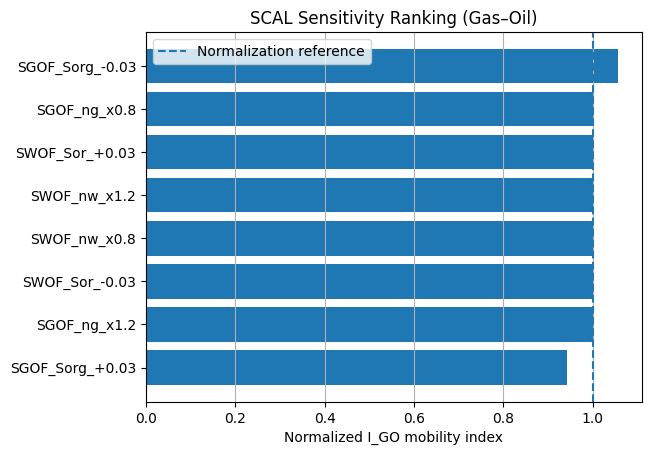

In [62]:
import matplotlib.pyplot as plt

order = df_sens.sort_values("I_GO_norm", ascending=True)

plt.figure()
plt.barh(order["case"], order["I_GO_norm"])
plt.axvline(1.0, linestyle="--", label="Normalization reference")
plt.xlabel("Normalized I_GO mobility index")
plt.title("SCAL Sensitivity Ranking (Gas–Oil)")
plt.legend()
plt.grid(True, axis="x")
plt.show()


In [63]:
baseline_wo = df_sens["I_WO_mobility"].median()
df_sens["I_WO_norm"] = df_sens["I_WO_mobility"] / baseline_wo


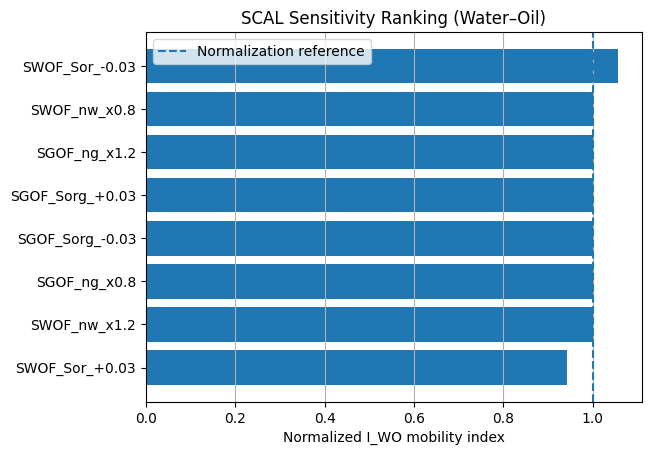

In [64]:
import matplotlib.pyplot as plt

order = df_sens.sort_values("I_WO_norm", ascending=True)

plt.figure()
plt.barh(order["case"], order["I_WO_norm"])
plt.axvline(1.0, linestyle="--", label="Normalization reference")
plt.xlabel("Normalized I_WO mobility index")
plt.title("SCAL Sensitivity Ranking (Water–Oil)")
plt.legend()
plt.grid(True, axis="x")
plt.show()


In [65]:
dP = Pp.max() - Pp.min()                 # MPa
dSigma = sigma_eff.max() - sigma_eff.min()  # MPa
dk_pct = (k_mult.max() - k_mult.min()) * 100
dphi_pct = (phi_mult.max() - phi_mult.min()) * 100

print(f"ΔP (avg reservoir) = {dP:.3f} MPa")
print(f"Δσ' (effective)    = {dSigma:.3f} MPa")
print(f"Δk (stress-induced)  ≈ {dk_pct:.6f} %")
print(f"Δφ (stress-induced)  ≈ {dphi_pct:.6f} %")


ΔP (avg reservoir) = 0.598 MPa
Δσ' (effective)    = 0.539 MPa
Δk (stress-induced)  ≈ 0.029923 %
Δφ (stress-induced)  ≈ 0.000598 %


In [5]:
import pandas as pd
import numpy as np

# Placeholder definitions for demonstration. Replace with your actual data.
time_array = np.arange(10) # Example: time steps from 0 to 9
avg_pressure = np.random.rand(10) * 100 + 1000 # Example: 10 random pressure values around 1000

# Placeholder definitions for production rates
oil_rate = np.random.rand(10) * 1000 # Example: 10 random oil rate values
water_rate = np.random.rand(10) * 500 # Example: 10 random water rate values
gas_rate = np.random.rand(10) * 10000 # Example: 10 random gas rate values

# assuming avg_pressure is a numpy array
df = pd.DataFrame({
    "time": time_array,       # e.g., number of timesteps or dates
    "avg_pressure": avg_pressure
})
df.to_csv("spe3_avg_pressure.csv", index=False)


In [6]:
df = pd.DataFrame({
    "time": time_array,
    "oil_rate": oil_rate,
    "water_rate": water_rate,
    "gas_rate": gas_rate
})
df.to_csv("spe3_production.csv", index=False)


In [9]:
import pandas as pd
from pathlib import Path

# Ensure df_swof_corey is defined. If not, try to load it from CSV.
if 'df_swof_corey' not in locals() and 'df_swof_corey' not in globals():
    try:
        output_dir = Path("/content/SPE3_SCAL_outputs")
        file_path = output_dir / "SPE3_SWOF_corey_fit.csv"
        df_swof_corey = pd.read_csv(file_path)
    except FileNotFoundError:
        print("Warning: 'SPE3_SWOF_corey_fit.csv' not found. Please ensure cell cx8RBDN1mBCV has been executed.")
        # Create an empty DataFrame as a fallback to avoid immediate errors
        df_swof_corey = pd.DataFrame(columns=["Sw", "krw_corey", "kro_corey", "pc"])

sw_array = df_swof_corey['Sw'].values
krw_array = df_swof_corey['krw_corey'].values
kro_array = df_swof_corey['kro_corey'].values
pc_array = df_swof_corey['pc'].values

df = pd.DataFrame({
    "sw": sw_array,
    "krw": krw_array,
    "kro": kro_array,
    "pc": pc_array
})
df.to_csv("spe3_scal_curves.csv", index=False)

In [10]:
from google.colab import files
files.download("spe3_avg_pressure.csv")
files.download("spe3_production.csv")
files.download("spe3_scal_curves.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MEM analyis

In [23]:
import numpy as np
import matplotlib.pyplot as plt


In [24]:
# Depth definition
z_top = 2000      # m
z_bottom = 2200   # m
n_layers = 10

depth = np.linspace(z_top, z_bottom, n_layers)
depth_km = depth / 1000.0


In [25]:
Sv_grad = 23.0     # MPa/km
Shmin_grad = 16.0  # MPa/km
SHmax_grad = 20.0  # MPa/km


In [26]:
Sv = Sv_grad * depth_km
Shmin = Shmin_grad * depth_km
SHmax = SHmax_grad * depth_km


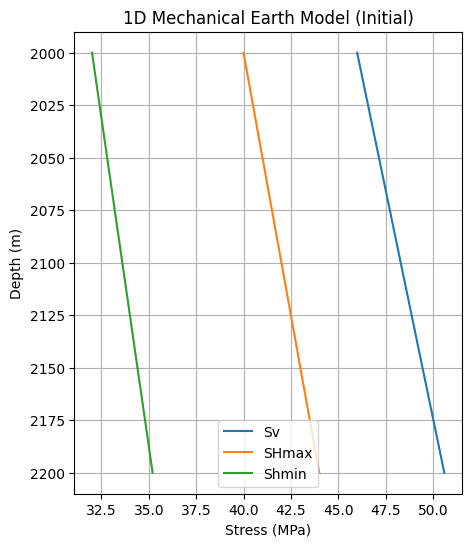

In [27]:
plt.figure(figsize=(5,6))
plt.plot(Sv, depth, label="Sv")
plt.plot(SHmax, depth, label="SHmax")
plt.plot(Shmin, depth, label="Shmin")

plt.gca().invert_yaxis()
plt.xlabel("Stress (MPa)")
plt.ylabel("Depth (m)")
plt.title("1D Mechanical Earth Model (Initial)")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# ~1000–1100  → THESE ARE psi
Pp_psi = np.array([
    1010.56, 1002.23, 1014.79, 1073.75, 1082.03,
    1073.25, 1089.02, 1069.15, 1026.38, 1026.58
])

Pp = Pp_psi * 0.00689476  # MPa


In [30]:
alpha = 0.9
Sv_mean = Sv.mean()

sigma_eff = Sv_mean - alpha * Pp


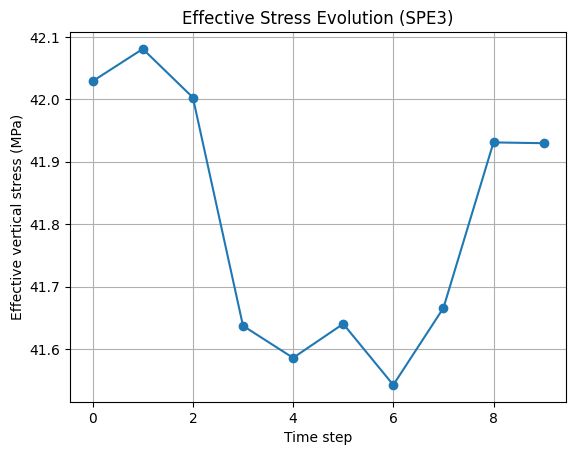

In [31]:
time = np.arange(len(Pp))

plt.figure()
plt.plot(time, sigma_eff, marker="o")
plt.xlabel("Time step")
plt.ylabel("Effective vertical stress (MPa)")
plt.title("Effective Stress Evolution (SPE3)")
plt.grid(True)
plt.show()


In [32]:
cr = 1e-5     # 1/MPa
P0 = Pp[0]

phi_mult = np.exp(-cr * (P0 - Pp))


In [33]:
ck = 5e-5
k_mult = np.exp(-ck * (P0 - Pp))


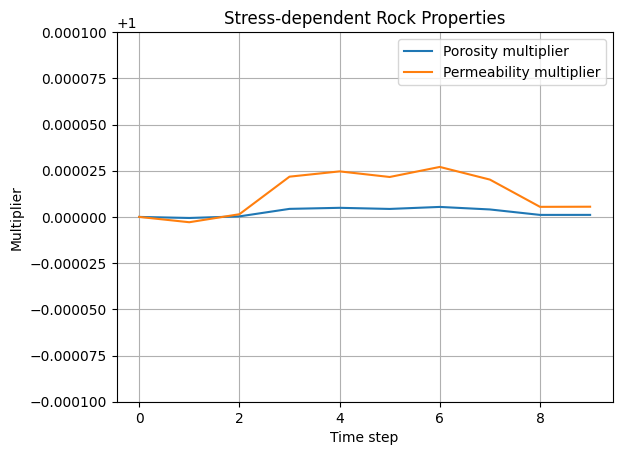

In [35]:
plt.figure()
plt.plot(time, phi_mult, label="Porosity multiplier")
plt.plot(time, k_mult, label="Permeability multiplier")

plt.ylim(0.9999, 1.0001)   # <-- critical
plt.xlabel("Time step")
plt.ylabel("Multiplier")
plt.legend()
plt.title("Stress-dependent Rock Properties")
plt.grid(True)
plt.show()


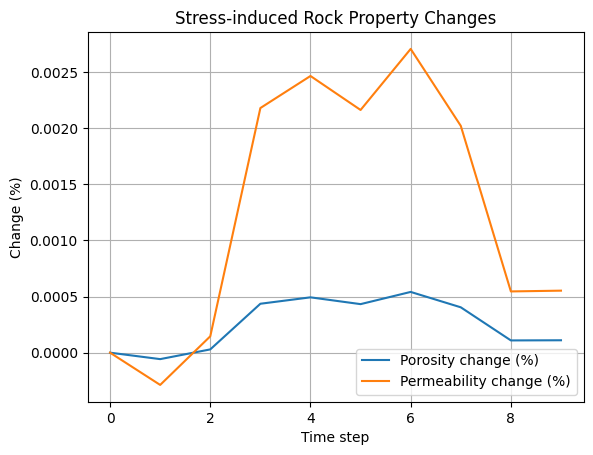

In [36]:
phi_pct = (phi_mult - 1.0) * 100
k_pct = (k_mult - 1.0) * 100

plt.figure()
plt.plot(time, phi_pct, label="Porosity change (%)")
plt.plot(time, k_pct, label="Permeability change (%)")
plt.xlabel("Time step")
plt.ylabel("Change (%)")
plt.legend()
plt.title("Stress-induced Rock Property Changes")
plt.grid(True)
plt.show()


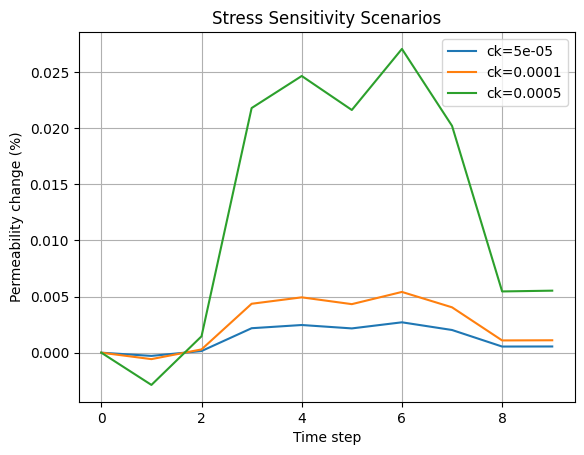

In [37]:
ck_scenarios = [5e-5, 1e-4, 5e-4]

for ck in ck_scenarios:
    k_mult = np.exp(-ck * (P0 - Pp))
    plt.plot(time, (k_mult - 1) * 100, label=f"ck={ck}")

plt.xlabel("Time step")
plt.ylabel("Permeability change (%)")
plt.legend()
plt.title("Stress Sensitivity Scenarios")
plt.grid(True)
plt.show()


MEM Dynamic

In [67]:
import numpy as np

# Replace avg_pressure_psi with your real pressure series
Pp_psi = np.array(avg_pressure, dtype=float)

# Convert psi -> MPa
Pp = Pp_psi * 0.00689476  # MPa

time = np.arange(len(Pp))
print("Pp (MPa) range:", Pp.min(), "to", Pp.max())

Pp (MPa) range: 6.91011988098753 to 7.508498342030683


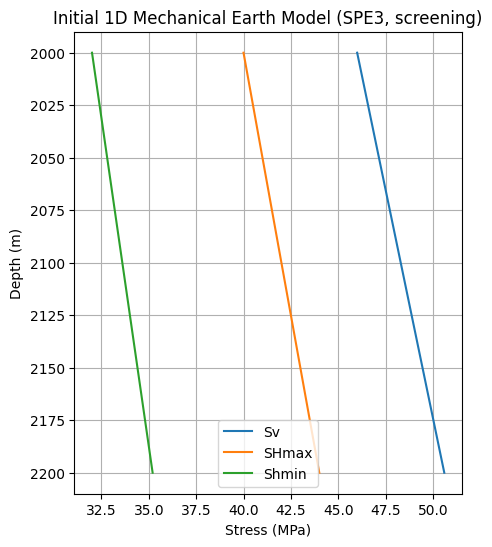

Mean Sv over interval (MPa): 48.300000000000004


In [68]:
import matplotlib.pyplot as plt

# Depth interval (m)
z_top, z_bottom, n_layers = 2000, 2200, 10
depth = np.linspace(z_top, z_bottom, n_layers)
depth_km = depth / 1000.0

# Stress gradients (MPa/km) - screening assumptions
Sv_grad = 23.0
SHmax_grad = 20.0
Shmin_grad = 16.0

Sv = Sv_grad * depth_km
SHmax = SHmax_grad * depth_km
Shmin = Shmin_grad * depth_km

plt.figure(figsize=(5,6))
plt.plot(Sv, depth, label="Sv")
plt.plot(SHmax, depth, label="SHmax")
plt.plot(Shmin, depth, label="Shmin")
plt.gca().invert_yaxis()
plt.xlabel("Stress (MPa)")
plt.ylabel("Depth (m)")
plt.title("Initial 1D Mechanical Earth Model (SPE3, screening)")
plt.legend()
plt.grid(True)
plt.show()

Sv_mean = Sv.mean()
print("Mean Sv over interval (MPa):", Sv_mean)


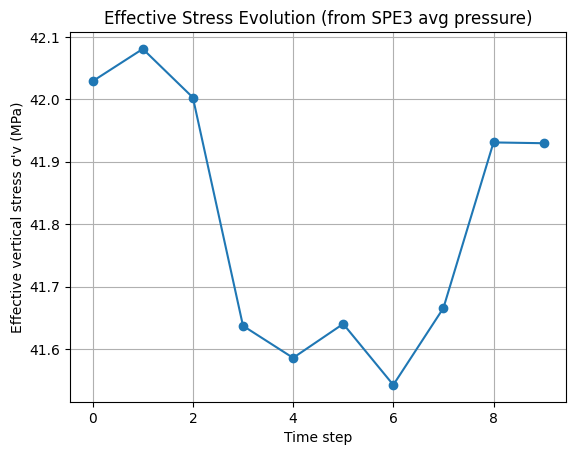

ΔP (MPa): 0.5983784610431533
Δσ' (MPa): 0.5385406149388388


In [69]:
alpha = 0.9  # Biot coefficient (assumption)

sigma_eff = Sv_mean - alpha * Pp  # MPa

plt.figure()
plt.plot(time, sigma_eff, marker="o")
plt.xlabel("Time step")
plt.ylabel("Effective vertical stress σ'v (MPa)")
plt.title("Effective Stress Evolution (from SPE3 avg pressure)")
plt.grid(True)
plt.show()

print("ΔP (MPa):", float(Pp.max() - Pp.min()))
print("Δσ' (MPa):", float(sigma_eff.max() - sigma_eff.min()))


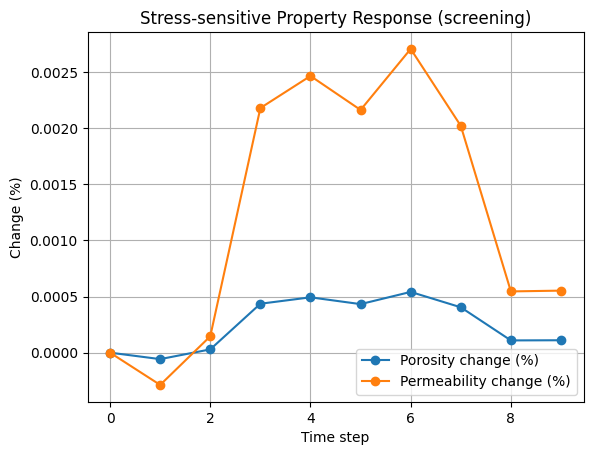

Δphi (%) ≈ 0.0005983799075681695
Δk (%)   ≈ 0.0029919284685764325


In [70]:
# Stress/pressure sensitivity coefficients (screening)
cr = 1e-5   # 1/MPa porosity sensitivity
ck = 5e-5   # 1/MPa permeability sensitivity

P0 = Pp[0]  # reference pressure (MPa)
phi_mult = np.exp(-cr * (P0 - Pp))
k_mult   = np.exp(-ck * (P0 - Pp))

# Plot as % change (readable)
phi_pct = (phi_mult - 1.0) * 100
k_pct   = (k_mult - 1.0) * 100

plt.figure()
plt.plot(time, phi_pct, marker="o", label="Porosity change (%)")
plt.plot(time, k_pct, marker="o", label="Permeability change (%)")
plt.xlabel("Time step")
plt.ylabel("Change (%)")
plt.title("Stress-sensitive Property Response (screening)")
plt.legend()
plt.grid(True)
plt.show()

print("Δphi (%) ≈", float(phi_pct.max() - phi_pct.min()))
print("Δk (%)   ≈", float(k_pct.max() - k_pct.min()))


In [71]:
print("Interpretation:")
print("- SPE3 pressure swing is modest, so Δσ' is < 1 MPa.")
print("- Stress-sensitive k and phi changes are therefore small (screening).")
print("- SCAL uncertainty (mobility ranking) is expected to dominate forecast variability in this benchmark.")
print("- Full coupling requires rerunning reservoir simulation with updated properties (future work).")


Interpretation:
- SPE3 pressure swing is modest, so Δσ' is < 1 MPa.
- Stress-sensitive k and phi changes are therefore small (screening).
- SCAL uncertainty (mobility ranking) is expected to dominate forecast variability in this benchmark.
- Full coupling requires rerunning reservoir simulation with updated properties (future work).
